code copied from 'Predicting Crypto Prices in Python' [https://youtu.be/GFSiL6zEZF0]

## import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from yahoo_fin.stock_info import get_data

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## load data

In [2]:
crypto_currency = 'ETH'
against_currency = 'USD'

start = dt.datetime(2018,6, 1)
end = dt.datetime.now()

data = get_data(f'{crypto_currency}-{against_currency}', start, end)

In [3]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-05-31,589.093018,567.664978,578.671997,580.043030,1.945890e+09,580.043030
2018-06-01,597.077026,577.322021,580.429016,591.807983,1.880390e+09,591.807983
2018-06-02,624.513000,591.258972,591.258972,618.328979,1.832550e+09,618.328979
2018-06-03,623.429016,583.747009,619.437012,592.984985,1.903430e+09,592.984985
2018-06-04,611.330017,580.981995,593.406006,609.302979,1.844270e+09,609.302979
...,...,...,...,...,...,...
2021-06-26,1979.958130,1811.245850,1830.996948,1978.894653,1.988547e+10,1978.894653
2021-06-27,2139.805420,1963.615479,1981.386475,2079.657471,2.551460e+10,2079.657471
2021-06-28,2242.238770,2076.240234,2083.448730,2160.768311,2.481512e+10,2160.768311


## Prepare Data

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60
future_day = 30

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Create Neural Network

In [5]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
33/33 [==============================] - 14s 106ms/step - loss: 0.0180
Epoch 2/25
33/33 [==============================] - 3s 104ms/step - loss: 0.0044
Epoch 3/25
33/33 [==============================] - 3s 105ms/step - loss: 0.0056
Epoch 4/25
33/33 [==============================] - 3s 87ms/step - loss: 0.0050
Epoch 5/25
33/33 [==============================] - 3s 84ms/step - loss: 0.0044
Epoch 6/25
33/33 [==============================] - 3s 93ms/step - loss: 0.0042
Epoch 7/25
33/33 [==============================] - 3s 90ms/step - loss: 0.0038
Epoch 8/25
33/33 [==============================] - 3s 78ms/step - loss: 0.0061
Epoch 9/25
33/33 [==============================] - 2s 69ms/step - loss: 0.0040
Epoch 10/25
33/33 [==============================] - 2s 59ms/step - loss: 0.0044
Epoch 11/25
33/33 [==============================] - 2s 69ms/step - loss: 0.0032
Epoch 12/25
33/33 [==============================] - 2s 66ms/step - loss: 0.0032
Epoch 13/25
33/33 [==============

## Testing the model

In [6]:
test_start = dt.datetime(2020, 6, 1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

In [7]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

## Plot test data

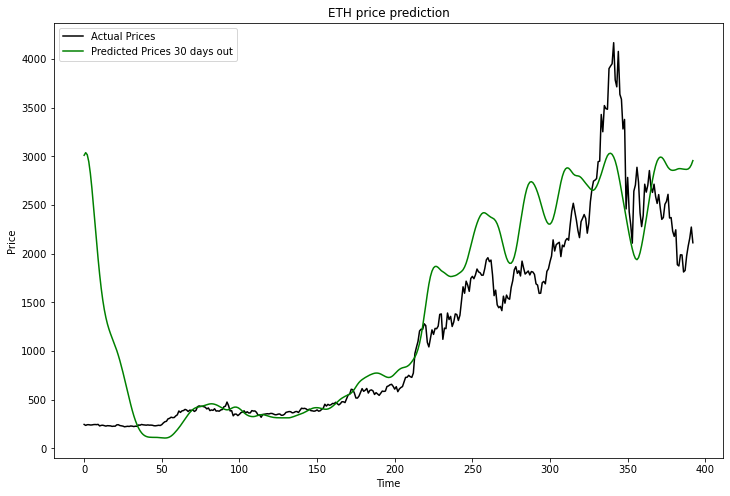

In [8]:
plt.figure(figsize=(12,8))
plt.plot(actual_prices, color="black", label='Actual Prices')
plt.plot(prediction_prices, color="green", label='Predicted Prices 30 days out')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

## Predict next day

In [9]:
real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs)+1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[3011.9578]]
